# Custom QDN implementation and evaluation

## List of Contents

### Provided classes
- [`default_params()`](#default_params) this dictionary defines the default hyper-parameters
- [`TransitionBatch`](#TransitionBatch) the basic class to summarize transitions and build an experience replay buffer.
- [`Runner`](#Runner) interacts with one environment
- [`MultiRunner`](#MultiRunner) runs multiple `Runner` in parallel
- [`QController`](#QController) translates the model outputs into greedy actions
- [`EpsilonGreedyController`](#EpsilonGreedyController) performs epsilon-greedy exploration
- [`QLearner`](#QLearner) trains the model with Q-learning loss
- [`Experment`](#Experiment) encapsulates and executes a single experiment
- [`QLearningExperiment`](#QLearningExperiment) performs online Q-learning



### Exercises
- [A2.1a) Run online Q-learning](#q1)
- [A2.1b) Use a replay buffer in Q-learning](#q2)
- [A2.1c) Implement target networks wth hard updates](#q3)
- [A2.1d) Implement target networks with soft updates](#q4)
- [A2.1e) Implement Double Q-learning](#q5)
- [A2.1f) Run double Q-learning on MountainCar](#q6)
- [A2.1g) Run double Q-learning on LunarLander](#q7)

In [1]:
# Pytorch and tools
import torch as th
from torch import Tensor, LongTensor
from torch.utils.data import DataLoader
import numpy as np
from copy import deepcopy
import numbers
from datetime import datetime
# Multi-threading
import threading
# Plotting
from IPython import display
import matplotlib.pyplot as plt
import pylab as pl
# Reinforcement learning
import gymnasium as gym
import cv2

This dictionary defines the default hyper-paramerters that you will use in your experiments. <a id=default_params></a>

In [2]:
def default_params():
    """ These are the default parameters used int eh framework. """
    return {# Debugging outputs and plotting during training
            'plot_frequency': 10,             # plots a debug message avery n steps
            'plot_train_samples': True,       # whether the x-axis is env.steps (True) or episodes (False)
            'print_when_plot': False,          # prints debug message if True
            'print_dots': False,              # prints dots for every gradient update
            # Environment parameters
            'env': 'CartPole-v1',             # the environment the agent is learning in
            'run_steps': 0,                   # samples whole episodes if run_steps <= 0
            'max_episode_length': 200,        # maximum number of steps per episode
            # Runner parameters
            'max_episodes': int(1E6),         # experiment stops after this many episodes
            'max_steps': int(1E9),            # experiment stops after this many steps
            'multi_runner': False,            # uses multiple runners if True
            'parallel_environments': 4,       # number of parallel runners  (only if multi_runner==True)
            # Exploration parameters
            'epsilon_anneal_time': int(5E3),  # exploration anneals epsilon over these many steps
            'epsilon_finish': 0.1,            # annealing stops at (and keeps) this epsilon
            'epsilon_start': 1,               # annealing starts at this epsilon
            # Optimization parameters
            'lr': 5E-4,                       # learning rate of optimizer
            'gamma': 0.99,                    # discount factor gamma
            'batch_size': 1024,               # number of transitions in a mini-batch    
            'grad_norm_clip': 1,              # gradent clipping if grad norm is larger than this 
            # DQN parameters
            'replay_buffer_size': int(1E5),   # the number of transitions in the replay buffer
            'use_last_episode': True,         # whether the last episode is always sampled from the buffer
            'target_model': True,             # whether a target model is used in DQN
            'target_update': 'soft',          # 'soft' target update or hard update by regular 'copy'
            'target_update_interval': 10,     # interval for the 'copy' target update
            'soft_target_update_param': 0.1,  # update parameter for the 'soft' target update
            'double_q': True,                 # whether DQN uses double Q-learning
            'grad_repeats': 1,                # how many gradient updates / runner call
            # Image input parameters          
            'pixel_observations': False,      # use pixel observations (we will not use this feature here)
            'pixel_resolution': (78, 78),     # scale image to this resoluton
            'pixel_grayscale': True,          # convert image into grayscale
            'pixel_add_last_obs': True,       # stacks 2 observations
            'pixel_last_obs_delay': 3,        # delay between the two stacked observations
           }

`TransitionBatches` are dictionaries of variables, e.g. states or actions, that are saved in contiguous Tensors. <a id=TransitionBatch></a>

In [3]:
class TransitionBatch:
    """ Simple implementation of a batchof transitionsm (or another dictionary-based tensor structure).
        Read and write operations are thread-safe, but the iterator is not (you cannot interate
        over the same TransitionBatch in two threads at the same time). """
    def __init__(self, max_size, transition_format, batch_size=32):
        self.lock = threading.Lock()
        self.indices = []
        self.size = 0
        self.first = 0
        self.max_size = max_size
        self.batch_size = batch_size
        self.dict = {}
        for key, spec in transition_format.items():
            self.dict[key] = th.zeros([max_size, *spec[0]], dtype=spec[1])
            
    def _clone_empty_batch(self, max_size=None, batch_size=None):
        """ Clones this TransitionBatch without cloning the data. """
        max_size = self.max_size if max_size is None else max_size
        batch_size = self.batch_size if batch_size is None else batch_size
        return TransitionBatch(max_size=max_size, transition_format={}, batch_size=batch_size)
        
    def __getitem__(self, key):
        """ Access the TransitionBatch with the [] operator. Use as key either 
            - the string name of a variable to get the full tensor of that variable,
            - a slice to get a time-slice over all variables in the batch,
            - a LongTensor that selects a subset of indices for all variables in the batch. """
        # Return the entry of the transition called "key"
        if isinstance(key, str): 
            return self.dict[key]
        # Return a slice of the batch
        if isinstance(key, slice):
            key = slice(0 if key.start is None else key.start, self.size if key.stop is None else key.stop,
                        1 if key.step is None else key.step)
            self.lock.acquire()
            try:
                batch = self._clone_empty_batch()
                batch.size = (key.stop - key.start) // key.step 
                for k, v in self.dict.items():
                    batch.dict[k] = v[key] 
            finally: self.lock.release()
            return batch
        # Collect and return a set of transitions specified by the LongTensor "key" 
        if isinstance(key, th.Tensor):
            #self.lock.acquire()
            #try:
                batch = self._clone_empty_batch(max_size=key.shape[0])
                batch.size = key.shape[0]
                for k, v in self.dict.items():
                    key = key.view(batch.size, *[1 for _ in range(len(v.shape[1:]))])
                    batch.dict[k] = v.gather(dim=0, index=key.expand(batch.size, *v.shape[1:]))
            #finally: self.lock.release()
                return batch
        return None
    
    def get_first(self):
        """ Returns a batch of the oldest entries of all variables. """
        batch = self._clone_empty_batch(max_size=1)
        self.lock.acquire()
        try:
            batch.size = 1
            for k, v in self.dict.items():
                batch.dict[k] = v[self.first].unsqueeze(dim=0)
        finally: self.lock.release()
        return batch    
    
    def get_last(self):
        """ Returns a batch of the newest entries of all variables. """
        batch = self._clone_empty_batch(max_size=1)
        self.lock.acquire()
        try:
            batch.size = 1
            for k, v in self.dict.items():
                batch.dict[k] = v[(self.first + self.size - 1) % self.size].unsqueeze(dim=0)
        finally: self.lock.release()
        return batch
    
    def add(self, trans:dict):
        """ Adding transition dictionaries, which can contain Tensors of arbitrary length. """
        if isinstance(trans, TransitionBatch):
            trans = trans.dict
        # Add all data in the dict
        self.lock.acquire()
        try:
            n = 0
            idx = None
            for k, v in trans.items():
                if idx is None:
                    n = v.shape[0]
                    idx = th.LongTensor([(self.first + self.size + i) % self.max_size for i in range(n)])
                else:
                    assert n == v.shape[0], 'all tensors in a transition need to have the same batch_size'
                idx = idx.view(idx.shape[0], *[1 for _ in range(len(v.shape) - 1)])
                self.dict[k].scatter_(dim=0, index=idx.expand_as(v), src=v)
            # Increase the size (and handle overflow)
            self.size += n
            if self.size > self.max_size:
                self.first = (self.first + n) % self.max_size
                self.size = self.max_size
        finally: self.lock.release()
        return self
            
    def trim(self):
        """ Reduces the length of the max_size to its actual size (in-place). Returns self. """
        self.lock.acquire()
        try:
            for k, v in self.dict.items():
                self.dict[k] = v[:self.size]
            self.max_size = self.size
        finally: self.lock.release()
        return self
    
    def replace(self, batch, index=0):
        """ Replaces parts of this batch with another batch (which must be smaller). """
        self.lock.acquire()
        try:
            assert batch.size <= self.max_size - index, "Replacement is larger then target area in batch."
            for k, v in batch.dict.items():
                if batch.size < batch.max_size:
                    v = v[:batch.size]
                self.dict[k][index:(index + batch.max_size)] = v    
        finally: self.lock.release()
    
    def sample(self):
        """ Samples a random mini-batch from the batch. """
        return self[th.randint(high=self.size, size=(self.batch_size,1))]
            
    def __len__(self): 
        """ Returns the length of the batch. """
        return self.size
    
    def __iter__(self):  
        """ Initializes an iterator over the batch. """
        self.indices = list(range(self.size))
        np.random.shuffle(self.indices)
        return self
    
    def __next__(self):  
        """ Iterates through batch, returns list of contiguous tensors. """
        if len(self.indices) == 0: raise StopIteration
        size = min(self.batch_size, len(self.indices))
        batch = self[th.LongTensor(self.indices[-size:])]
        self.indices = self.indices[:-size]
        return batch

`Runner` implements a simple runner class that uses a controller to interact with the environment by calling `run()` or `run_episode()`. <a id=Runner></a>

In [4]:
class Runner:
    """ Implements a simple single-thread runner class. """
    def __init__(self, controller, params={}, exploration_step=1):
        self.env = gym.make(params.get('env', 'CartPole-v0'))
        self.cont_actions = isinstance(self.env.action_space, gym.spaces.Box)
        self.controller = controller
        self.epi_len = params.get('max_episode_length', self.env._max_episode_steps)
        self.gamma = params.get('gamma', 0.99)
        self.use_pixels = params.get('pixel_observations', False)
        if self.use_pixels:
            self.grayscale = params.get('pixel_grayscale', True)
            self.add_last_obs = params.get('pixel_add_last_obs', False)
            self.last_obs_delay = params.get('pixel_last_obs_delay', 4)
            n_colors = 1 if self.grayscale else 3
            n_feats = n_colors * (2 if self.add_last_obs else 1)
            resolution = params.get('pixel_resolution', (25, 25))
            self.state_shape = (n_feats, *resolution)
            self.last_observations = TransitionBatch(max_size=self.last_obs_delay, 
                                                     transition_format={'img': ((n_colors, *resolution), th.float32)})
        else:
            self.state_shape = self.env.observation_space.shape
        # Set up current state and time step
        self.sum_rewards = 0
        self.state = None
        self.time = 0
        self._next_step() 
        
    def close(self):
        """ Closes the underlying environment. Should always when ending an experiment. """
        self.env.close()
    
    def transition_format(self):
        """ Returns the format of transtions: a dictionary of (shape, dtype) entries for each key. """
        return {'actions': ((1,), th.long),
                'states': (self.state_shape, th.float32),
                'next_states': (self.state_shape, th.float32),
                'rewards': ((1,),  th.float32),
                'dones': ((1,), th.bool),
                'returns': ((1,), th.float32)}
    
    def _wrap_transition(self, s, a, r, ns, d):
        """ Takes a transition and returns a corresponding dictionary. """
        trans = {}
        form = self.transition_format()
        for key, val in [('states', s), ('actions', a), ('rewards', r), ('next_states', ns), ('dones', d)]:
            if not isinstance(val, th.Tensor): 
                if isinstance(val, numbers.Number) or isinstance(val, bool): val = [val]
                val = th.tensor(val, dtype=form[key][1])
            if len(val.shape) < len(form[key][0]) + 1: val = val.unsqueeze(dim=0)
            trans[key] = val
        return trans
    
    def _pixel_observation(self, reset=False):
        """ Returns the pixel-observation fo the current state. Opens extra window for rendering. """
        img = self.env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=self.state_shape[1:], interpolation=cv2.INTER_CUBIC)
        img = th.from_numpy(img.astype(np.float32) / 255).transpose(dim0=0, dim1=2).unsqueeze(dim=0)
        if self.grayscale: img = img.mean(dim=1, keepdim=True)
        if self.add_last_obs:
            if reset: self.last_observations.size = 0
            if self.last_observations.size < self.last_observations.max_size:
                obs = img * 0
            else:
                obs = self.last_observations.get_first()['img'].clone()
            self.last_observations.add({'img': img})
            img = th.cat([obs, img], dim=1)
        return img
    
    def _run_step(self, a):
        """ Make a step in the environment (and update internal bookeeping) """
        ns, r, t, d, _ = self.env.step(a.item())
        self.sum_rewards += r
        if self.use_pixels: ns = self._pixel_observation()
        return r, ns, t, d or t  # reward, next state, terminal, done
    
    def _next_step(self, done=True, next_state=None):
        """ Switch to the next time-step (and update internal bookeeping) """
        self.time = 0 if done else self.time + 1
        if done:
            self.sum_rewards = 0
            self.state, _ = self.env.reset()
            if self.use_pixels: self.state = self._pixel_observation(reset=True)
        else:
            self.state = next_state
    
    def run(self, n_steps, transition_buffer=None, trim=True, return_dict=None):
        """ Runs n_steps in the environment and stores them in the trainsition_buffer (newly created if None).
            If n_steps <= 0, stops at the end of an episode and optionally trins the transition_buffer.
            Returns a dictionary containing the transition_buffer and episode statstics. """
        my_transition_buffer = TransitionBatch(n_steps if n_steps > 0 else self.epi_len, self.transition_format())
        time, episode_start, episode_lengths, episode_rewards = 0, 0, [], []
        max_steps = n_steps if n_steps > 0 else self.epi_len
        for t in range(max_steps):
            # One step in the envionment
            a = self.controller.choose(self.state)
            r, ns, terminal, done = self._run_step(a)
            my_transition_buffer.add(self._wrap_transition(self.state, a, r, ns, terminal)) 
            if self.env._elapsed_steps == self.epi_len: done = True
            # Compute discounted returns if episode has ended or max_steps has been reached
            if done or t == (max_steps - 1):
                my_transition_buffer['returns'][t] = my_transition_buffer['rewards'][t]
                for i in range(t - 1, episode_start - 1, -1):
                    my_transition_buffer['returns'][i] = my_transition_buffer['rewards'][i] \
                                                         + self.gamma * my_transition_buffer['returns'][i + 1]
                episode_start = t + 1
            # Remember statistics and advance (potentially initilaizing a new episode)
            if done:
                episode_lengths.append(self.time + 1)
                episode_rewards.append(self.sum_rewards)
            self._next_step(done=done, next_state=ns)
            time += 1
            # If n_steps <= 0, we return after one episode (trimmed if specified)
            if done and n_steps <= 0: 
                my_transition_buffer.trim()
                break
        # Add the sampled transitions to the given transition buffer
        transition_buffer = my_transition_buffer if transition_buffer is None \
                            else transition_buffer.add(my_transition_buffer)
        if trim: transition_buffer.trim()
        # Return statistics (mean reward, mean length and environment steps)
        if return_dict is None: return_dict = {}
        return_dict.update({'buffer': transition_buffer,
                            'episode_reward': None if len(episode_rewards) == 0 else np.mean(episode_rewards),
                            'episode_length': None if len(episode_lengths) == 0 else np.mean(episode_lengths),
                            'env_steps': time})
        return return_dict
        
    def run_episode(self, transition_buffer=None, trim=True, return_dict=None):
        """ Runs one episode in the environemnt. 
            Returns a dictionary containing the transition_buffer and episode statstics. """
        return self.run(0, transition_buffer, trim, return_dict)

`MultiRunner` runs a number of `Runner` instances in parallel. <a id=MultiRunner></a>

In [5]:
class MultiRunner:
    """ Simple class that runs multiple Runner objects in parallel and merges their outputs. """
    def __init__(self, controller, params={}):
        self.workers = []
        self.runners = []
        n = params.get('parallel_environments', 1)
        for _ in range(n):
            self.runners.append(Runner(controller=controller, params=params))
            
    def transition_format(self):
        """ Same transition-format as underlying Runners. """
        return self.runners[0].transition_format()
    
    def close(self):
        """ Closes the underlying environment. Should always when ending an experiment. """
        # Join all workers
        for w in self.workers:
            w.join()
        # Exit all environments
        for r in self.runners:
            r.close()
    
    def fork(self, target, common_args=None, specific_args=None):
        """ Executes the function "target" on all runners. "common_args" is a dictionary of 
            arguments that are passed to all runners, "specific_args" is a list of 
            dictionaries that contain individual parameters for each runner. """ 
        # Fork all runners
        self.workers = []
        for i, r in enumerate(self.runners):
            r_args = [] if specific_args is None else [arg[i] for arg in specific_args]
            self.workers.append(threading.Thread(target=target, args=(r, *common_args, *r_args)))
            self.workers[-1].start()
        # Join all runners
        for w in self.workers:
            w.join()
    
    def run(self, n_steps, transition_buffer=None, trim=True):
        """ Runs n_steps, split amongst runners, and stores them in the trainsition_buffer (newly created if None).
            If n_steps <= 0, stops at the end of an episode and optionally trims the transition_buffer.
            Returns a dictionary containing the transition_buffer and episode statstics. """
        n_steps = n_steps // len(self.runners)
        if transition_buffer is None:
            buffer_len = len(self.runners) * (n_steps if n_steps > 0 else self.runners[0].epi_len)
            transition_buffer = TransitionBatch(buffer_len, self.runners[0].transition_format())
        return_dicts = [{} for _ in self.runners]
        self.fork(target=Runner.run, common_args=(n_steps, transition_buffer, False), specific_args=(return_dicts,))
        if trim: transition_buffer.trim()
        rewards = [d['episode_reward'] for d in return_dicts if d['episode_reward'] is not None]
        lengths = [d['episode_length'] for d in return_dicts if d['episode_reward'] is not None]
        return {'buffer': transition_buffer, 
                'episode_reward': np.mean(rewards) if len(rewards) > 0 else None,
                'episode_length': np.mean(lengths) if len(lengths) > 0 else None,
                'env_steps': len(transition_buffer)}

    def run_episode(self, transition_buffer=None, trim=True):
        """ Runs one episode in the environemnt. 
            Returns a dictionary containing the transition_buffer and episode statstics. """
        return self.run(0, transition_buffer, trim)

A `QController` translates model responses into actions. Call `choose()` to select actions or `probabilities()` to get the probabilities with which the controller would choose the actions. <a id=QController></a>

In [6]:
class QController:
    """ Controller for Q-value functions, synchronizes the model calls. """
    def __init__(self, model, num_actions=None, params={}):
        self.lock = threading.Lock()
        self.num_actions = model[-1].out_features if num_actions is None else num_actions
        self.model = model
        
    def copy(self):
        """ Shallow copy of this controller that does not copy the model. """
        return QController(model=self.model, num_actions=self.num_actions)
        
    def parameters(self):
        """ Returns a generator of the underlying model parameters. """
        return self.model.parameters()
    
    def sanitize_inputs(self, observation, **kwargs):
        """ Casts numpy arrays as Tensors. """
        if isinstance(observation, np.ndarray):
            observation = th.Tensor(observation).unsqueeze(dim=0)
        return observation
                
    def choose(self, observation, **kwargs):
        """ Returns the greedy actions the agent would choose when facing an "observation". """
        self.lock.acquire()
        try: 
            mx = self.model(self.sanitize_inputs(observation))
            if mx.shape[-1] > self.num_actions: mx = mx[:, :self.num_actions]
        finally: self.lock.release()
        return th.max(mx, dim=-1)[1]

    def probabilities(self, observation, **kwargs):
        """ Returns the probabilities with which the agent would choose actions (here one-hot because greedy). """
        self.lock.acquire()
        try: 
            mx = self.model(self.sanitize_inputs(observation))
            if mx.shape[-1] > self.num_actions: mx = mx[:, :self.num_actions]
        finally: self.lock.release()
        return th.zeros(*mx.shape).scatter_(dim=-1, index=th.max(mx, dim=-1)[1].unsqueeze(dim=-1), src=th.ones(1, 1))

An `EpsilonGreedyController` is a controller that autonomously anneals an expsilon greedy exploration strategy. <a id=EpsilonGreedyController></a>

In [7]:
class EpsilonGreedyController:
    """ A wrapper that makes any controller into an epsilon-greedy controller. 
        Keeps track of training-steps to decay exploration automatically. """
    def __init__(self, controller, params={}, exploration_step=1):
        self.controller = controller
        self.num_actions = controller.num_actions
        self.max_eps = params.get('epsilon_start', 1.0)
        self.min_eps = params.get('epsilon_finish', 0.05)
        self.anneal_time = int(params.get('epsilon_anneal_time', 10000) / exploration_step)
        self.num_decisions = 0
    
    def epsilon(self):
        """ Returns current epsilon. """
        return max(1 - self.num_decisions / (self.anneal_time - 1), 0) \
                * (self.max_eps - self.min_eps) + self.min_eps
    
    def choose(self, observation, increase_counter=True, **kwargs):
        """ Returns the (possibly random) actions the agent takes when faced with "observation".
            Decays epsilon only when increase_counter=True". """
        eps = self.epsilon()
        if increase_counter: self.num_decisions += 1
        if np.random.rand() < eps: 
            return th.randint(self.controller.num_actions, (1,), dtype=th.long)
        else: 
            return self.controller.choose(observation, **kwargs)
    
    def probabilities(self, observation, **kwargs):
        """ Returns the probabilities with which the agent would choose actions. """
        eps = self.epsilon()
        return eps * th.ones(1, 1) / self.num_actions + \
               (1 - eps) * self.controller.probabilities(observation, **kwargs) 

A `QLearner` is a learner class that performs Q-learning. At the moment this does not include target models or double Q-learning, which you will add in later exercises. <a id=QLearner></a>

In [8]:
class QLearner:
    """ A basic learner class that performs Q-learning train() steps. """
    def __init__(self, model, params={}):
        self.model = model
        self.all_parameters = list(model.parameters())
        self.gamma = params.get('gamma', 0.99)
        self.optimizer = th.optim.Adam(self.all_parameters, lr=params.get('lr', 5E-4))
        self.criterion = th.nn.MSELoss() 
        self.grad_norm_clip = params.get('grad_norm_clip', 10)
        self.target_model = None  # Target models are not yet implemented!
    
    def target_model_update(self):
        """ This function updates the target network. No target network is implemented yet. """
        pass

    def q_values(self, states, target=False):
        """ Reutrns the Q-values of the given "states". 
            I supposed to use the target network if "target=True", but this is not implemented here. """
        return self.model(states)
                    
    def _current_values(self, batch):
        """ Computes the Q-values of the 'states' and 'actions' of the given "batch". """
        qvalues = self.q_values(batch['states'])
        return qvalues.gather(dim=-1, index=batch['actions'])
        
    def _next_state_values(self, batch):
        """ Computes the Q-values of the 'next_states' of the given "batch".
            Is greedy w.r.t. to current Q-network or target-network, depending on parameters. """
        with th.no_grad():  # Next state values do not need gradients in DQN
            # Compute the next states values (with target or current network)
            qvalues = self.q_values(batch['next_states'], target=True)
            # Compute the maximum over Q-values
            return qvalues.max(dim=-1, keepdim=True)[0]
    
    def train(self, batch):
        """ Performs one gradient decent step of DQN. """
        self.model.train(True)
        # Compute TD-loss
        targets = (batch['rewards'] + self.gamma * (~batch['dones'] * self._next_state_values(batch)))
        loss = self.criterion(self._current_values(batch), targets.detach())
        # Backpropagate loss
        self.optimizer.zero_grad()
        loss.backward()
        grad_norm = th.nn.utils.clip_grad_norm_(self.all_parameters, self.grad_norm_clip)
        self.optimizer.step()
        # Update target network (if specified) and return loss
        self.target_model_update()
        return loss.item()

An `Experiment` is an abstract class that starts and maintains a single learning experiment (i.e. random seed). The experiment is started using `run()` and can be interrupted at any time using `close()`. Afterwards the experiment can be restarted at any time calling `run()` again. <a id=Experiment></a>

In [9]:
class Experiment:
    """ Abstract class of an experiment. Contains logging and plotting functionality."""
    def __init__(self, params, model, **kwargs):
        self.params = params
        self.plot_frequency = params.get('plot_frequency', 100)
        self.plot_train_samples = params.get('plot_train_samples', True)
        self.print_when_plot = params.get('print_when_plot', False)
        self.print_dots = params.get('print_dots', False)
        self.episode_returns = []
        self.episode_lengths = []
        self.episode_losses  = []
        self.env_steps = []
        self.total_run_time = 0.0
        
    def plot_training(self, update=False):
        """ Plots logged training results. Use "update=True" if the plot is continuously updated
            or use "update=False" if this is the final call (otherwise there will be double plotting). """ 
        # Smooth curves
        window = max(int(len(self.episode_returns) / 50), 10)
        if len(self.episode_losses) < window + 2: return
        returns = np.convolve(self.episode_returns, np.ones(window)/window, 'valid')
        lengths = np.convolve(self.episode_lengths, np.ones(window)/window, 'valid')
        losses = np.convolve(self.episode_losses, np.ones(window)/window, 'valid')
        env_steps = np.convolve(self.env_steps, np.ones(window)/window, 'valid')
        # Determine x-axis based on samples or episodes
        if self.plot_train_samples:
            x_returns = env_steps
            x_losses = env_steps[(len(env_steps) - len(losses)):]
        else:
            x_returns = [i + window for i in range(len(returns))]
            x_losses = [i + len(returns) - len(losses) + window for i in range(len(losses))]
        # Create plot
        colors = ['b', 'g', 'r']
        fig = plt.gcf()
        fig.set_size_inches(16, 4)
        plt.clf()
        # Plot the losses in the left subplot
        pl.subplot(1, 3, 1)
        pl.plot(env_steps, returns, colors[0])
        pl.xlabel('environment steps' if self.plot_train_samples else 'episodes')
        pl.ylabel('episode return')
        # Plot the episode lengths in the middle subplot
        ax = pl.subplot(1, 3, 2)
        ax.plot(env_steps, lengths, colors[0])
        ax.set_xlabel('environment steps' if self.plot_train_samples else 'episodes')
        ax.set_ylabel('episode length')
        # Plot the losses in the right subplot
        ax = pl.subplot(1, 3, 3)
        ax.plot(x_losses, losses, colors[0])
        ax.set_xlabel('environment steps' if self.plot_train_samples else 'episodes')
        ax.set_ylabel('loss')
        # dynamic plot update
        display.clear_output(wait=True)
        if update:
            display.display(pl.gcf())
    
    def close(self):
        """ Frees all allocated runtime ressources, but allows to continue the experiment later. 
            Calling the run() method after close must be able to pick up the experiment where it was. """
        pass
    
    def run(self):
        """ Starts (or continues) the experiment. """
        assert False, "You need to extend the Expeirment class and override the method run(). "

`QLearningExperiment` performs online Q-learning using `QLearner`. One can specify another learner, which you will do in later exercises. <a id=QLearningExperiment></a>

In [10]:
class QLearningExperiment (Experiment):
    """ Experiment that perfoms DQN. You can provide your own learner. """
    def __init__(self, params, model, learner=None, **kwargs):
        super().__init__(params, model, **kwargs)
        self.max_episodes = params.get('max_episodes', int(1E6))
        self.max_steps = params.get('max_steps', int(1E9))
        self.run_steps = params.get('run_steps', 0)
        self.grad_repeats = params.get('grad_repeats', 1)
        self.controller = QController(model, num_actions=gym.make(params['env']).action_space.n, params=params)
        self.controller = EpsilonGreedyController(controller=self.controller, params=params)
        self.runner = MultiRunner(self.controller, params=params) if params.get('multi_runner', True) \
                      else Runner(self.controller, params=params)
        self.learner = QLearner(model, params=params) if learner is None else learner

    def close(self):
        """ Overrides Experiment.close(). """
        self.runner.close()
        
    def _learn_from_episode(self, episode):
        """ This function uses the episode to train.
            Although not implemented, one could also add the episode to a replay buffer here.
            Returns the training loss for logging or None if train() was not called. """
        # Call train (params['grad_repeats']) times
        total_loss = 0
        for i in range(self.grad_repeats):
            total_loss += self.learner.train(episode['buffer']) 
        return total_loss / self.grad_repeats
    
    def run(self):
        """ Starts (or continues) the experiment. """
        # Plot previous results if they exist
        if self.plot_frequency is not None and len(self.episode_losses) > 2:
            self.plot_training(update=True)
        # Start (or continue experiment)
        env_steps = 0 if len(self.env_steps) == 0 else self.env_steps[-1]
        for e in range(self.max_episodes):
            begin_time = datetime.now()
            # Run an episode (or parts of it)
            if self.run_steps > 0:
                episode = self.runner.run(n_steps=self.run_steps, trim=False)
            else:
                episode = self.runner.run_episode()
            # Log the results
            env_steps += episode['env_steps']
            if episode['episode_length'] is not None:
                self.episode_lengths.append(episode['episode_length'])
                self.episode_returns.append(episode['episode_reward'])
                self.env_steps.append(env_steps)
            # Make one (or more) learning steps with the episode
            loss = self._learn_from_episode(episode)
            if episode['episode_length'] is not None and loss is not None: self.episode_losses.append(loss)
            self.total_run_time += (datetime.now() - begin_time).total_seconds()
            # Quit if maximal number of environment steps is reached
            if env_steps >= self.max_steps:
                break
            # Show intermediate results
            if self.print_dots:
                print('.', end='')
            if self.plot_frequency is not None and (e + 1) % self.plot_frequency == 0 \
                                               and len(self.episode_losses) > 2:
                self.plot_training(update=True)
                if self.print_when_plot:
                    print('Update %u, 100-epi-return %.4g +- %.3g, length %u, loss %g, run-time %g sec.' % 
                          (len(self.episode_returns), np.mean(self.episode_returns[-100:]), 
                           np.std(self.episode_returns[-100:]), np.mean(self.episode_lengths[-100:]), 
                           np.mean(self.episode_losses[-100:]), self.total_run_time))

In [11]:
class DQNExperiment (QLearningExperiment):
    """ Experiment that perfoms DQN. You can provide your own learner. """
    def __init__(self, params, model, learner=None, **kwargs):
        super().__init__(params, model, learner=learner, **kwargs)
        self.use_last_episode = params.get('use_last_episode', True)
        self.replay_buffer = TransitionBatch(params.get('replay_buffer_size', int(1E5)), 
                                             self.runner.transition_format(), 
                                             batch_size=params.get('batch_size', 1024))

    def _learn_from_episode(self, episode):
        self.replay_buffer.add(episode['buffer'])
        # Make a gradient update step
        if self.replay_buffer.size >= self.replay_buffer.batch_size:
            # Call train() params['grad_repeats'] times
            total_loss = 0
            for i in range(self.grad_repeats):
                sampled_batch = self.replay_buffer.sample()
                if self.use_last_episode: 
                    sampled_batch.replace(episode['buffer'] if len(sampled_batch) >= len(episode['buffer']) 
                                                            else episode['buffer'][:len(sampled_batch)])
                total_loss += self.learner.train(sampled_batch)
            # returned the averaged loss
            return total_loss / self.grad_repeats
        else:
            return None


class QLearnerHardTarget (QLearner):
    def __init__(self, model, params={}):
        super().__init__(model, params)
        self.target_update = params.get('target_update', 'copy')
        self.target_update_interval = params.get('target_update_interval', 200)
        self.target_update_calls = 0
        if params.get('target_model', True):
            self.target_model = deepcopy(model)
            for p in self.target_model.parameters():
                p.requires_grad = False
        assert self.target_model is None or self.target_update == 'soft' or self.target_update == 'copy',\
            'If a target model is specified, it needs to be updated using the "soft" or "copy" options.'
    
    def target_model_update(self):
        """ This function updates the target network. """
        if self.target_model is not None:
            # Target network update by copying it every so often
            if self.target_update == 'copy':
                self.target_update_calls = (self.target_update_calls + 1) % self.target_update_interval
                if self.target_update_calls == 0:
                    self.target_model.load_state_dict(self.model.state_dict())

    def q_values(self, states, target=False):
        """ Reutrns the Q-values of the given "states". Uses the target network if "target=True". """
        target = target and self.target_model is not None
        return (self.target_model if target else self.model)(states)
    
    
class QLearnerSoftTarget (QLearnerHardTarget):
    def __init__(self, model, params={}):
        super().__init__(model, params)
        self.target_update = params.get('target_update', 'soft')
        self.soft_target_update_param = params.get('soft_target_update_param', 0.1)
    
    def target_model_update(self):
        """ This function updates the target network. """
        if self.target_model is not None:
            # Target network update by copying it every so often
            if self.target_update == 'copy':
                super().target_model_update()
            elif self.target_update == 'soft':
                for tp, mp in zip(self.target_model.parameters(), self.model.parameters()):
                    tp *= (1 - self.soft_target_update_param)
                    tp += self.soft_target_update_param * mp.detach()
                    

class DoubleQLearner (QLearnerSoftTarget):
    def __init__(self, model, params={}):
        super().__init__(model, params)
        self.double_q = params.get('double_q', True)
    
    def _next_state_values(self, batch):
        """ Computes the Q-values of the 'next_states' of the given "batch".
            Is greedy w.r.t. to current Q-network or target-network, depending on parameters. """
        with th.no_grad():  # Next state values do not need gradients in DQN
            # Compute the next states values (with target or current network)
            qvalues = self.q_values(batch['next_states'], target=True)
            # Compute the maximum (note the case of double Q-learning)
            if self.target_model is None or not self.double_q:
                # If we do not do double Q-learning or if there is not target network
                qvalues = qvalues.max(dim=-1, keepdim=True)[0]
            else:
                # If we do double Q-learning
                next_values = self.q_values(batch['next_states'], target=False)
                actions = next_values.max(dim=-1)[1].unsqueeze(dim=-1)
                qvalues = qvalues.gather(dim=-1, index=actions)
            return qvalues

## A2.1a) Run the given online Q-learning algorithm <a id=q1></a>
Go through the implementation in the given Jupyter Notebook. Run online Q-learning, that is, use the `QLearningExperiment` with the `QLearner` class on the `CartPole-v1` environment for 200*k* steps in the environment.

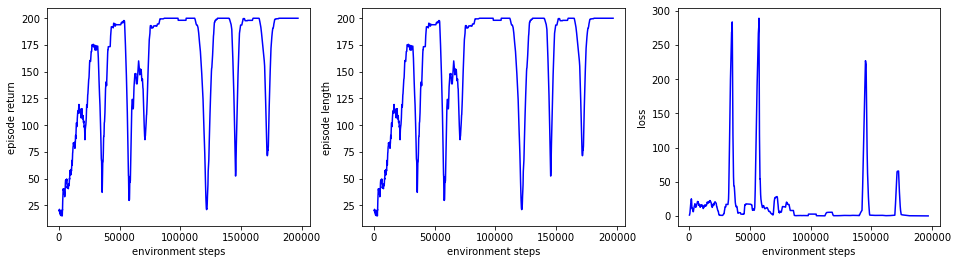

In [12]:
# A2.1a) Run the given Online Q-learning algorithm without target networks or experience replay
# Executing this code-block defines a new experiment
params = default_params()
params['max_steps'] = int(2E5)
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = QLearningExperiment(params, model, learner=QLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A2.1b) Use a replay buffer in Q-learning <a id=q2></a>
Implement online Q-learning with an experience replay buffer by extending the given
skeleton of the `DQNExperiment` class. Train your implementation again in the `CartPole-v1`
environment for 200*k* steps.

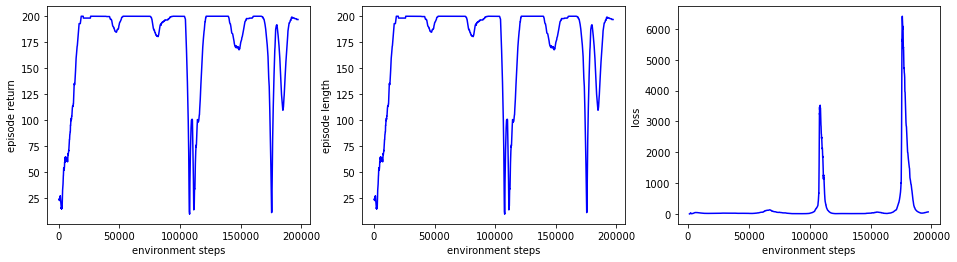

In [13]:
# A2.1b) Extend the QLearningExperiment class to use a replay buffer during training.
#        If the replay buffer does not contain enough transitions for a mini-batch, training should be omitted.
#        Bonus: make sure the last episode is always used for optimization (params['use_last_episode']=True)
class DQNExperiment (QLearningExperiment):
    """ Experiment that perfoms DQN. You can provide your own learner. """
    def __init__(self, params, model, learner=None, **kwargs):
        super().__init__(params, model, learner=learner, **kwargs)
        self.use_last_episode = params.get('use_last_episode', True)
        self.replay_buffer = TransitionBatch(params.get('replay_buffer_size', int(1E5)), 
                                             self.runner.transition_format(), 
                                             batch_size=params.get('batch_size', 1024))

    def _learn_from_episode(self, episode):
        self.replay_buffer.add(episode['buffer'])
        # Make a gradient update step
        if self.replay_buffer.size >= self.replay_buffer.batch_size:
            # Call train() params['grad_repeats'] times
            total_loss = 0
            for i in range(self.grad_repeats):
                sampled_batch = self.replay_buffer.sample()
                if self.use_last_episode: 
                    sampled_batch.replace(episode['buffer'] if len(sampled_batch) >= len(episode['buffer']) 
                                                            else episode['buffer'][:len(sampled_batch)])
                total_loss += self.learner.train(sampled_batch)
            # returned the averaged loss
            return total_loss / self.grad_repeats
        else:
            return None
        

# Executing this code-block defines a new experiment
params = default_params()
params['max_steps'] = int(2E5) 
params['use_last_episode'] = True
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = DQNExperiment(params, model)

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A2.1c) Implement target networks with hard updates <a id=q3></a>
Extend the `QLearning` class with target-networks that use a hard update rule. Train
your implementation again in the `CartPole-v1` environment for 200*k* steps.

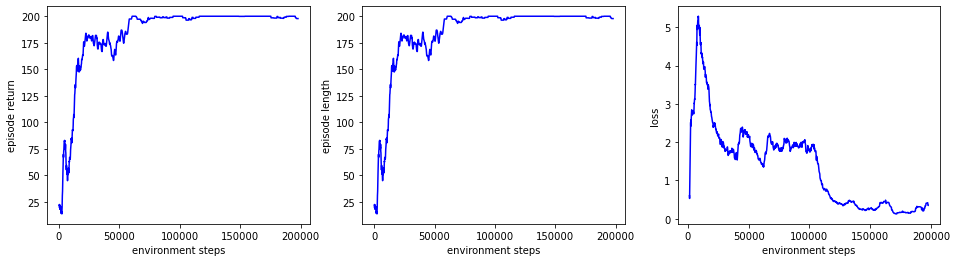

In [14]:
# A2.1c) Implement a target network with hard target updates (params['target_update'] = 'copy') 
#        every (params['target_update_interval'] = 10) gradient update steps.
#        Make sure (params['target_model'] = False) maintains the old functionality.
#        Hint: use (self.target_model.load_state_dict(self.model.state_dict())) to copy the model
class QLearnerHardTarget (QLearner):
    def __init__(self, model, params={}):
        super().__init__(model, params)
        self.target_update = params.get('target_update', 'copy')
        self.target_update_interval = params.get('target_update_interval', 200)
        self.target_update_calls = 0
        if params.get('target_model', True):
            self.target_model = deepcopy(model)
            for p in self.target_model.parameters():
                p.requires_grad = False
        assert self.target_model is None or self.target_update == 'soft' or self.target_update == 'copy',\
            'If a target model is specified, it needs to be updated using the "soft" or "copy" options.'
    
    def target_model_update(self):
        """ This function updates the target network. """
        if self.target_model is not None:
            # Target network update by copying it every so often
            if self.target_update == 'copy':
                self.target_update_calls = (self.target_update_calls + 1) % self.target_update_interval
                if self.target_update_calls == 0:
                    self.target_model.load_state_dict(self.model.state_dict())

    def q_values(self, states, target=False):
        """ Reutrns the Q-values of the given "states". Uses the target network if "target=True". """
        target = target and self.target_model is not None
        return (self.target_model if target else self.model)(states)


# Executing this code-block defines a new experiment
params = default_params()
params['max_steps'] = int(2E5)
params['target_model'] = True 
params['target_update'] = 'copy'
params['target_update_interval'] = 10
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = DQNExperiment(params, model, learner=QLearnerHardTarget(model, params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A2.1d) Implement target networks with soft updates <a id=q4></a>
Extend your implementation with a soft-update rule for the target network and test it in
the environment `CartPole-v1` for 200*k* steps.

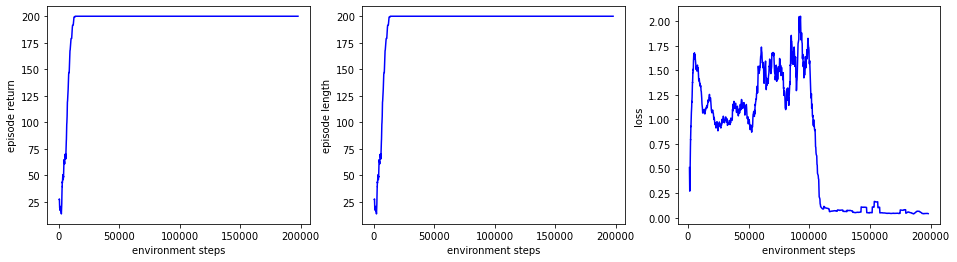

In [15]:
# A2.1d) Implement a target network with soft target updates (params['target_update'] = 'soft'). 
#        The decay parameter is given by params['soft_target_update_param').
#        Make sure all other parameters maintain the old functionality.
#        Hint: you can iterate through model.parameters()
class QLearnerSoftTarget (QLearnerHardTarget):
    def __init__(self, model, params={}):
        super().__init__(model, params)
        self.target_update = params.get('target_update', 'soft')
        self.soft_target_update_param = params.get('soft_target_update_param', 0.1)
    
    def target_model_update(self):
        """ This function updates the target network. """
        if self.target_model is not None:
            # Target network update by copying it every so often
            if self.target_update == 'copy':
                super().target_model_update()
            elif self.target_update == 'soft':
                for tp, mp in zip(self.target_model.parameters(), self.model.parameters()):
                    tp *= (1 - self.soft_target_update_param)
                    tp += self.soft_target_update_param * mp.detach()


# Executing this code-block defines a new experiment
params = default_params()
params['max_steps'] = int(2E5)
params['target_model'] = True
params['target_update'] = 'soft'
params['soft_target_update_param'] = 0.1
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = DQNExperiment(params, model, learner=QLearnerSoftTarget(model, params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A2.1e) Implement double Q-learning <a id=q5></a>
Extend your implementation with double-Q-learning and test it in the `CartPole-v1` environment for 200*k* steps.

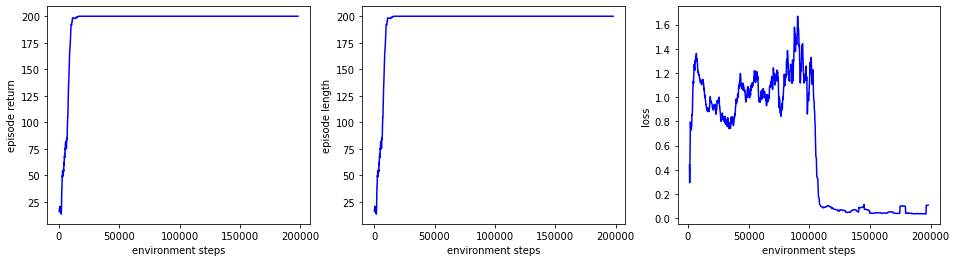

In [16]:
# A2.1e) Implement double Q-leanring when (params['double_q'] = True)
class DoubleQLearner (QLearnerSoftTarget):
    def __init__(self, model, params={}):
        super().__init__(model, params)
        self.double_q = params.get('double_q', True)
    
    def _next_state_values(self, batch):
        """ Computes the Q-values of the 'next_states' of the given "batch".
            Is greedy w.r.t. to current Q-network or target-network, depending on parameters. """
        with th.no_grad():  # Next state values do not need gradients in DQN
            # Compute the next states values (with target or current network)
            qvalues = self.q_values(batch['next_states'], target=True)
            # Compute the maximum (note the case of double Q-learning)
            if self.target_model is None or not self.double_q:
                # If we do not do double Q-learning or if there is not target network
                qvalues = qvalues.max(dim=-1, keepdim=True)[0]
            else:
                # If we do double Q-learning
                next_values = self.q_values(batch['next_states'], target=False)
                actions = next_values.max(dim=-1)[1].unsqueeze(dim=-1)
                qvalues = qvalues.gather(dim=-1, index=actions)
            return qvalues


# Executing this code-block defines a new experiment
params = default_params()
params['max_steps'] = int(2E5)
params['double_q'] = True
params['soft_target_update_param'] = 0.1
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = DQNExperiment(params, model, learner=DoubleQLearner(model, params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A2.1f) Run double Q-learning on MountainCar <a id=q6></a>
Run your implementation of `DoubleQLearner` on the `MountainCar-v0` environment for 200*k* steps. In all likelihood, your agent will not be able to solve the task (reach the goal), and learning should not pick up at all. Explain why that is.

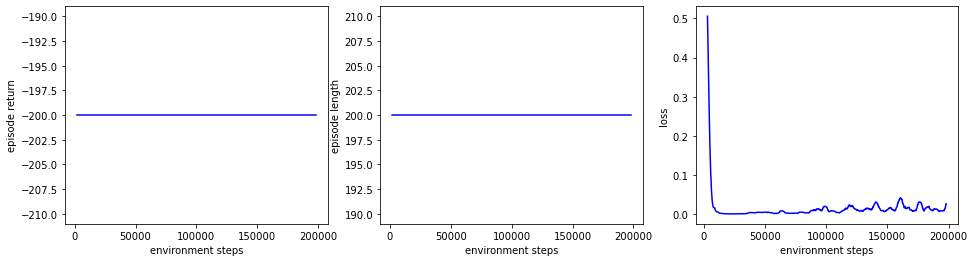

In [17]:
# A2.1f) Run your implementation of DoubleQLearner on the MountainCar-v0 environment.
#        Why does the agent not learn to solve the task?

# Executing this code-block defines a new experiment
params = default_params()
params['env'] = 'MountainCar-v0'
params['max_steps'] = int(2E5)
params['epsilon_anneal_time'] = int(1E5)  # exploration is probably important  
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = DQNExperiment(params, model, learner=DoubleQLearner(model, params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

## A2.1g) Run double Q-learning on LunarLander <a id=q7></a>
Run your implementation on the `LunarLander-v2` environment for at least 5 million environment steps (more is better). This can take a while, expect 1-3 hours of computation time. Do you get similar results as shown in the lecture?

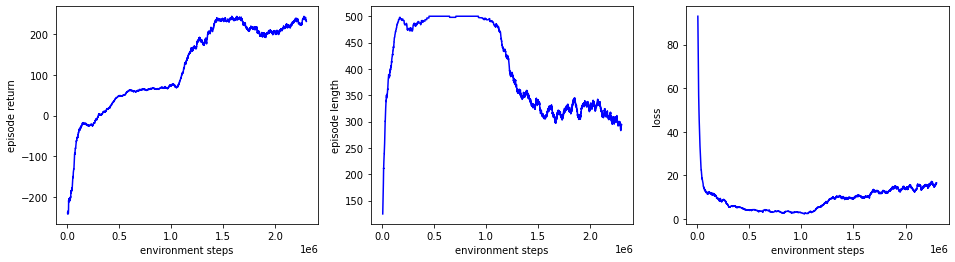

In [ ]:
# A2.1g) Run your implementation on the LunarLander-v2 environment for at least 2 million
#        environment steps (more is better), with one gradient update step every 50 environmental steps and
#        a maximal episode length of 500. This can take a while, expect 1-2 hours of computation time.
#        Be warned, some systems experience a memory leak, so keep an eye on your memory.
#        Do you get similar curves for "episode return", "epsode length" and "loss" as in the lecture? 

# Executing this code-block defines a new experiment
params = default_params()
params['env'] = 'LunarLander-v2'
params['max_steps'] = int(2E6)
params['max_episode_length'] = 500
params['run_steps'] = 50
# These parameters worked well for me:
params['soft_target_update_param'] = 0.005  # slower learning, but more stability
params['replay_buffer_size'] = int(1E6)     # more memory allows better learning
params['plot_frequency'] = 100              # not too many plots (on my system ever 2-3 seconds)
# Define model and experiment object
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
experiment = DQNExperiment(params, model, learner=DoubleQLearner(model, params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()